In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, model_selection # Scikit-learn (sklearn)

import torch
from torch import nn # PyTorch's building blocks for neural networks
from torchmetrics import MeanAbsolutePercentageError

torch.__version__

'1.10.2'

<br>

## 1. Data loading & preprocessing

In [12]:
df = pd.DataFrame(datasets.load_boston().data) # make a pandas DataFrame from numpy array
df.head() # 머리를 영어로?

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [14]:
datasets.load_boston().target[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [25]:
x_data = datasets.load_boston().data 
y_data = datasets.load_boston().target # 집의 가격 (in $1,000s)

y_data = y_data.reshape(-1, 1) # PyTorch 기반 regression에서는 label을 2차원 행렬 형태로 준비

<br>

## 2. Devide dataframe into X & Y -> Train X / Test X / Train Y / Test Y

In [26]:
X = torch.from_numpy(np.array(x_data)).type(torch.float)
y = torch.from_numpy(np.array(y_data)).type(torch.float)

In [27]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(X, y,
                                                                                 test_size=0.3,
                                                                                 random_state=0)
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

torch.Size([354, 13])
torch.Size([152, 13])
torch.Size([354, 1])
torch.Size([152, 1])


<br>

## 3. Build & Train the model 

<br>
<br>

### 1) Build the model

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

In [17]:
class MLP_Regressor(nn.Module):
    
    
    def __init__(self, num_features, num_output, num_nodes=64):
        
        super().__init__()
        
        self.sequential_stack = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=num_nodes),
            # nn.BatchNorm1d(num_nodes),
            nn.ELU(),
            nn.Linear(in_features=num_nodes, out_features=num_nodes),
            nn.ELU(), 
            nn.Linear(in_features=num_nodes, out_features=num_nodes),
            nn.ELU(), 
            nn.Dropout(0.4),
            nn.Linear(in_features=num_nodes, out_features=num_output)
        )
    
    def forward(self, x):
        
        return self.sequential_stack(x)

<br>
<br>

### 2) Check the model

In [18]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = MLP_Regressor(num_features=13, 
                      num_output=1, 
                      num_nodes=64).to(device)

In [19]:
model.eval()

with torch.inference_mode(): 
    
    untrained_preds = model(test_data.to(device)) # 모델 & 데이터는 동일한 디바이스 위에 위치해있어야 함
    
print(untrained_preds[:10])

tensor([[-1.5760],
        [-1.0718],
        [-2.3296],
        [-0.9687],
        [-1.6619],
        [-2.4397],
        [-1.1993],
        [-2.8504],
        [-1.9557],
        [-1.5431]])


<br>
<br>

### 3) Train the model

In [52]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = MLP_Regressor(num_features=13, 
                      num_output=1, 
                      num_nodes=64).to(device)

In [53]:
loss_fn = nn.MSELoss() # Mean squared error

optimizer = torch.optim.Adam(params=model.parameters(),  # "parameters" to optimize (apply gradient descent)
                             lr=0.001) # "l"earning "r"ate 

metric_MAPE = MeanAbsolutePercentageError().to(device)

In [54]:
torch.manual_seed(42)


train_data, train_label = train_data.to(device), train_label.to(device)
test_data, test_label   = test_data.to(device), test_label.to(device)
 
    
loss_train_list = []
loss_test_list = []
mape_train_list = []
mape_test_list = []

for epoch in range(1000):
    
    # 모델을 training mode로 설정 (default state)
    model.train()

    # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    y_predicted = model(train_data)
    
    # 2. Training cost 계산 (Cost function 계산)
    loss_train = loss_fn(y_predicted, train_label) # <- nn.MSELoss()
    loss_train_list.append(loss_train.item())
    
    # 3. Optimizer 내부의 이전 gradient 값 초기화 (Make "grad" to "zero")
    optimizer.zero_grad()

    # 4. Back-propagation ("Backward" propagation)
    loss_train.backward()

    # 5. Gradient descent 진행 (Take a "step" to update parameters)
    optimizer.step()

    
    # 모델을 evaluation mode로 설정
    model.eval()
    
    with torch.inference_mode(): # Set "inference mode"
        
        # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        y_predicted_test = model(test_data)
        
        # Test cost 계산
        loss_test = loss_fn(y_predicted_test, test_label)
        loss_test_list.append(loss_test.item())
        

    mape_train = metric_MAPE(y_predicted, train_label) 
    mape_train_list.append(mape_train.item())
    
    mape_test  = metric_MAPE(y_predicted_test, test_label)
    mape_test_list.append(mape_test.item())
    
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, MAPE: {mape_train:.2f}% | Test loss: {loss_test:.5f}, Test MAPE: {mape_test:.2f}%")

Epoch: 0 | Loss: 718.11432, MAPE: 1.10% | Test loss: 485.27103, Test MAPE: 0.88%
Epoch: 100 | Loss: 74.04300, MAPE: 0.28% | Test loss: 62.77225, Test MAPE: 0.26%
Epoch: 200 | Loss: 42.76999, MAPE: 0.22% | Test loss: 42.13508, Test MAPE: 0.20%
Epoch: 300 | Loss: 34.49626, MAPE: 0.19% | Test loss: 34.89547, Test MAPE: 0.15%
Epoch: 400 | Loss: 26.41702, MAPE: 0.18% | Test loss: 23.62934, Test MAPE: 0.15%
Epoch: 500 | Loss: 22.61296, MAPE: 0.16% | Test loss: 27.01965, Test MAPE: 0.15%
Epoch: 600 | Loss: 23.41981, MAPE: 0.16% | Test loss: 21.94859, Test MAPE: 0.15%
Epoch: 700 | Loss: 17.67697, MAPE: 0.15% | Test loss: 21.27418, Test MAPE: 0.15%
Epoch: 800 | Loss: 19.83934, MAPE: 0.16% | Test loss: 22.80237, Test MAPE: 0.14%
Epoch: 900 | Loss: 18.12682, MAPE: 0.16% | Test loss: 22.19954, Test MAPE: 0.16%


<br>

## 4. Test the model 

In [66]:
# 1. 모델을 evaluation mode로 설정
model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    y_predicted = model(test_data.to(device))
    
mape_test = metric_MAPE(y_predicted, test_label.to(device)) 

print('Test MAPE : {:.4f} %'.format(mape_test))

Test MAPE : 0.1625 %


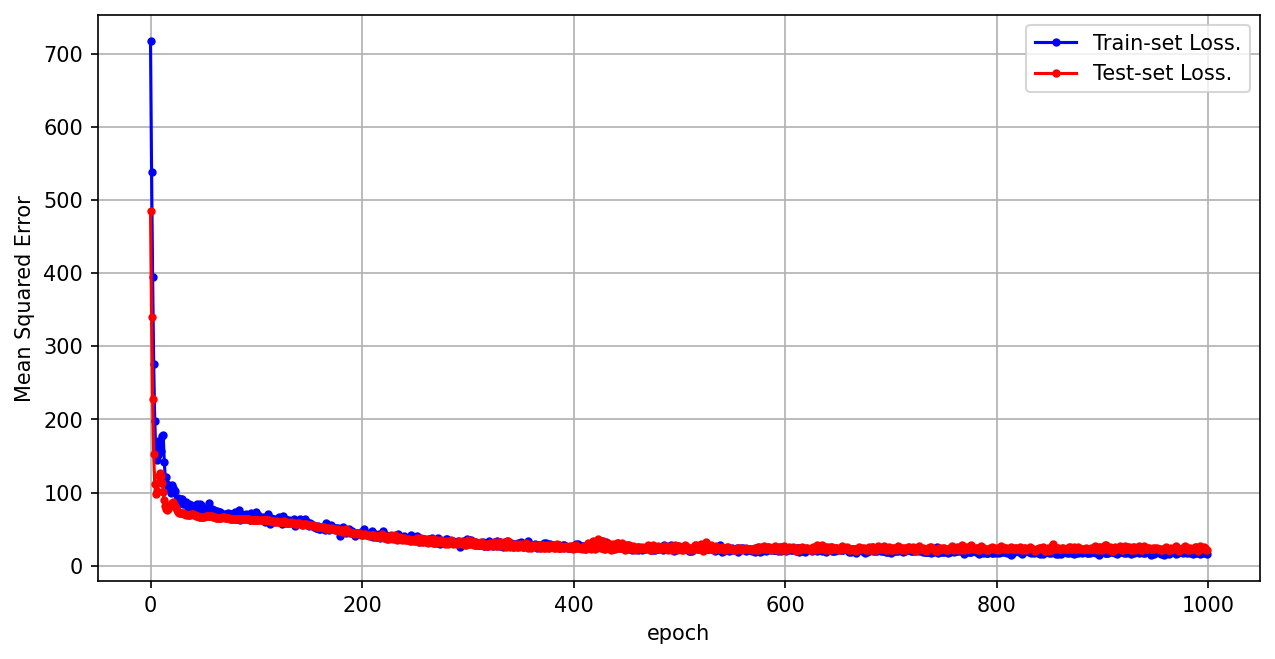

In [56]:
epochs = np.arange(len(loss_train_list))

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(epochs, loss_train_list, marker='.', c='blue', label="Train-set Loss.")
plt.plot(epochs, loss_test_list, marker='.', c='red', label="Test-set Loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Mean Squared Error')
plt.show()

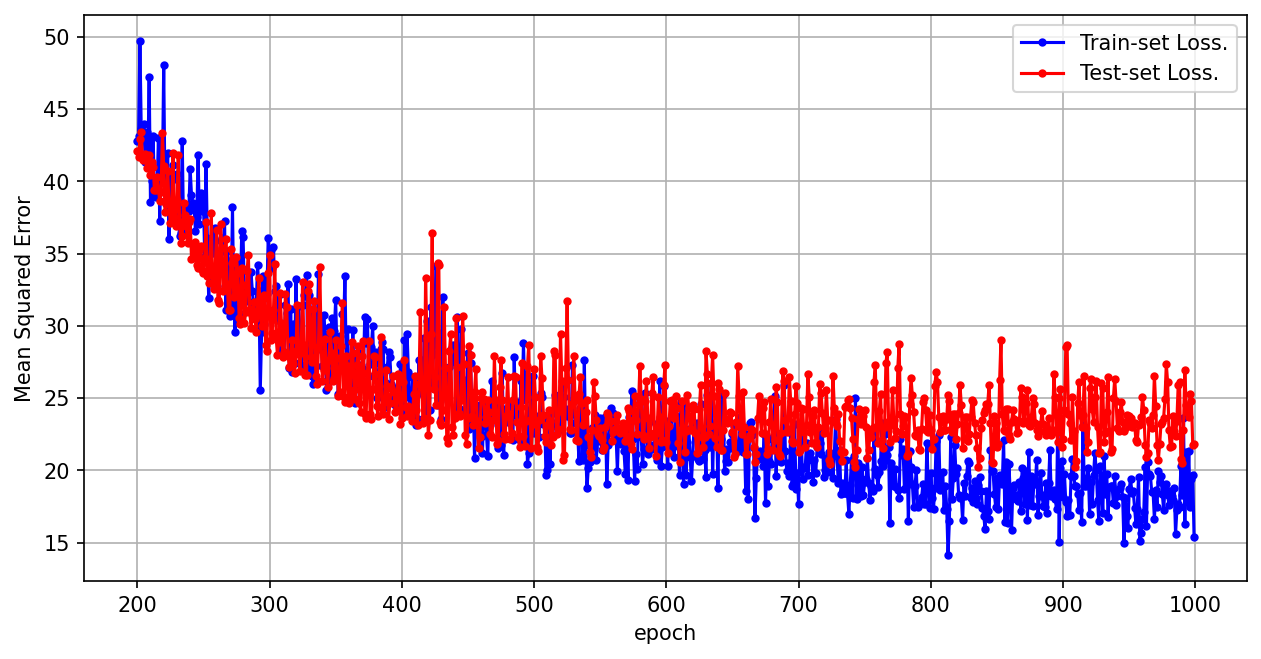

In [57]:
epochs = np.arange(len(loss_train_list))

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(epochs[200:], loss_train_list[200:], marker='.', c='blue', label="Train-set Loss.")
plt.plot(epochs[200:], loss_test_list[200:], marker='.', c='red', label="Test-set Loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Mean Squared Error')
plt.show()

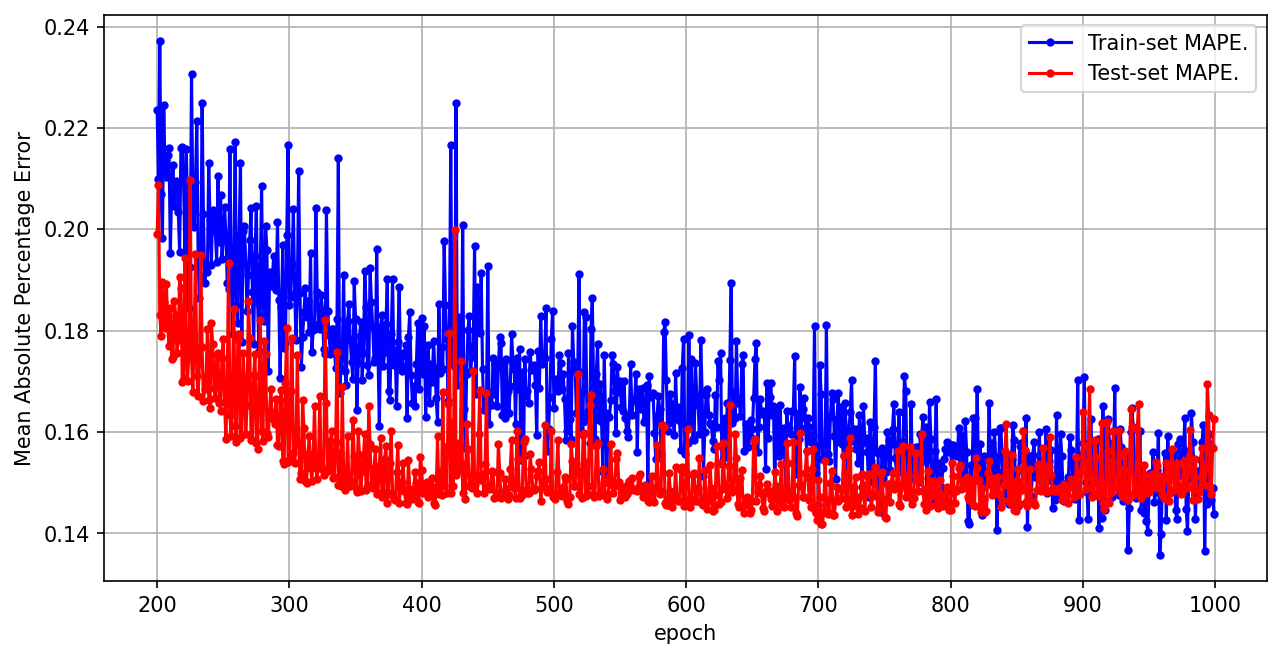

In [59]:
epochs = np.arange(len(loss_train_list))

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(epochs[200:], mape_train_list[200:], marker='.', c='blue', label="Train-set MAPE.")
plt.plot(epochs[200:], mape_test_list[200:], marker='.', c='red', label="Test-set MAPE.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Mean Absolute Percentage Error')
plt.show()

In [61]:
sample_data = np.array([[0.02731, 0.0, 7.07, 0.0, 0.469, 6.421, 78.9, 4.9671, 2.0, 242.0, 17.8, 396.90, 9.14]])
data_tensor = torch.from_numpy(sample_data).type(torch.float)


# 1. 모델을 evaluation mode로 설정
model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    prediction = model(data_tensor.to(device))

print(prediction.item())

25.5824031829834


<br>

## 5. Save the model 

<br>

#### * 모델을 통째로 저장하고 불러오는 것도 가능 @ https://pytorch.org/tutorials/beginner/saving_loading_models.html

#### -> **torch.save(model, PATH)** & **model = torch.load(PATH)**

In [62]:
# Shorter version

torch.save(obj=model.state_dict(), # only parameters
           f='models/usethis_regressor.pth')

In [63]:
# # Longer version (디렉토리부터 생성)


# # 1. 모델 파라미터 파일 저장을 위한 디렉토리 생성 (os.mkdir 함수로 대체하여 사용 가능)

# from pathlib import Path
# MODEL_PATH = Path("models")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)
# # parents=True : any missing parents of this path are created as needed.
# # exist_ok=True : FileExistsError exceptions will be ignored.


# # 2. 모델 파라미터 저장경로 지정 

# MODEL_NAME = "usethis_regressor.pth" # common convention for PyTorch saved models or objects : .pt or .pth
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME # WindowsPath('models/usethis_regressor.pth')


# # 3. 모델 파라미터 저장

# print('Saving model to :', MODEL_SAVE_PATH)

# torch.save(obj=model.state_dict(), # only parameters
#            f=MODEL_SAVE_PATH)

In [64]:
loaded_model = MLP_Regressor(num_features=13, 
                             num_output=1, 
                             num_nodes=64) # 모델 구조 생성 

loaded_model.load_state_dict(torch.load(f='models/usethis_regressor.pth')) 
# pickle 파일을 먼저 load 후 paramter 값들을 꺼내어 모델로 load

loaded_model.to(device)

MLP_Regressor(
  (sequential_stack): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [67]:
# 1. 모델을 evaluation mode로 설정
loaded_model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    y_predicted = model(test_data.to(device))
    
mape_test = metric_MAPE(y_predicted, test_label.to(device)) 

print('Test MAPE : {:.4f} %'.format(mape_test))

Test MAPE : 0.1625 %
